Подключим все необходимые библиотеки для вычислений и для визуализации

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

Определим функцию для решения системы с трехдиагональной матрицей

In [2]:
def tridiagonal_algorithm(a,b,c,f):
    a, b, c, f = tuple(map(lambda k_list: list(map(float, k_list)), (a, b, c, f)))

    alpha = [-b[0] / c[0]]
    beta = [f[0] / c[0]]
    n = len(f)
    x = [0]*n

    for i in range(1, n):
        alpha.append(-b[i]/(a[i]*alpha[i-1] + c[i]))
        beta.append((f[i] - a[i]*beta[i-1])/(a[i]*alpha[i-1] + c[i]))

    x[n-1] = beta[n - 1]

    for i in range(n - 1, 0, -1):
        x[i - 1] = alpha[i - 1]*x[i] + beta[i - 1]

    return x

В соответствии с входными данными определим функции:

- $k(x) = 4-x^2$ -- это коэффициент теплопроводности материала стержня;

- $q(x) = x^2$ отвечает за мощность стоков или источников тепла;

- $f(x)=4\cos x - 2 x\sin x$ -- это плотность распределения внешних источников или стоков тепла;

- $\mu_1 = 1$;

- $\sigma_2 = \tan 1$;

Также нам понадобится функция

- $k'(x) = -2x$.

In [4]:
def k(x):
    return 4 - x**2

def dkdx(x):
    return -2*x

def q(x):
    return x**2

def f(x):
    return 4*np.cos(x) - 2*x*np.sin(x)

mu_1 = 1
sigma_2 = np.tan(1)

Определим функцию, соответствующую точному решению дифференциальной задачи $$u(x) = \cos x$$

In [30]:
def u(x):
    return np.cos(x)

Определим сетку узлов $\omega_h$ следующим образом: пусть $[a,b] = [0,1]$, а число разбиений отрезка $N = 5$.

In [31]:
a, b = 0, 1
N = 5
x = np.linspace(start=a, stop=b, num=N+1)
h = (b-a)/N

## Разностная аппроксимация

Итак, у нас есть разностная схема
$$\begin{dcases}
			\dfrac{k_{i+\frac12}y_{i+1} - k_{i+\frac12} y_i -k_{i-\frac12} y_i + k_{i-\frac12} y_{i-1} }{h^2} - q(x_i) y_i = -f(x_i),\ i = \overline{1, N-1},\\
			y_0 = \mu_1,\\
			- \dfrac{y_N - y_{N-1}}{h} = \left[\sigma_2\cdot \left(1 + \dfrac h2 \cdot\dfrac { k'(1)}{ k(1)}\right) + \dfrac h 2 \cdot \dfrac {q(1)}{k(1)} \right] y_N - \dfrac h 2 \cdot \dfrac {f(1)}{k(1)}
		\end{dcases}$$
Чтобы найти с помощью нее приближенное решение дифференциальной задачи, нам нужно преобразовать эту разностную схему к задаче на решение системы с трехиадогнальной матрицей. Таким образом, задача на решение системы уравнений примет вид
$$
		\begin{pmatrix} 
			\gamma_0 & \beta_0 & 0 & \ldots & 0 & 0 & \vrule & g_0 \\ 
			\alpha_1 & \gamma_1 & \beta_1 & \ldots & 0 & 0 & \vrule & g_1\\ 
			0 & \alpha_1 & \gamma_2 & \ldots & 0 & 0 & \vrule & g_2\\ 
			\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vrule & \vdots\\ 
			0 & 0 & 0 & \ldots& \gamma_{N-1} & \beta_{N-1} & \vrule & g_{N-1} \\ 
			0 & 0 & 0 & \ldots& \alpha_N& \gamma_N & \vrule & g_N\\\end{pmatrix}
$$
где
	$$\gamma_0 = 1,\ \beta_0 = 0,\ g_0 = \mu_1,$$
	$$\alpha_i = \dfrac{k(x_i - \frac h2)}{h^2},\ \gamma_i = -\dfrac{k(x_i - \frac h2) + k(x_i + \frac h2)}{h^2} - q(x_i), \ \beta_i =\dfrac{k(x_i + \frac h2)}{h^2},\ g_i = -f(x_i),$$
	$$\alpha_N = \dfrac 1 h,\ \gamma_N = -\left[\dfrac 1h + \sigma_2\cdot \left(1 + \dfrac h2 \cdot\dfrac { k'(1)}{ k(1)}\right) + \dfrac h 2 \cdot \dfrac {q(1)}{k(1)}\right],\ g_N = - \dfrac h 2 \cdot \dfrac {f(1)}{k(1)}.$$
Реализуем вычисление всех коэффициентов:

In [36]:
gamma = [1]
beta = [0]
g = [mu_1]
alpha = [0]
for i in range(1, N):
    alpha.append(k(x[i] - h/2) / h**2)
    gamma.append(-(k(x[i] - h/2) + k(x[i] + h/2)) / h**2 - q(x[i]))
    beta.append(k(x[i] + h/2) / h**2)
    g.append(-f(x[i]))
alpha.append(1/h)
gamma.append(- (1/h + sigma_2 * (1 + h/2 * dkdx(1) / k(1)) + h/2 * q(1) / k(1)))
g.append(-h/2 * f(1) / k(1))
beta.append(0)

Теперь определим приближенное решение разностной задачи как решение системы с трехдиагональной матрицей

In [37]:
y = tridiagonal_algorithm(alpha,beta,gamma,g)

Визуализируем полученные результаты

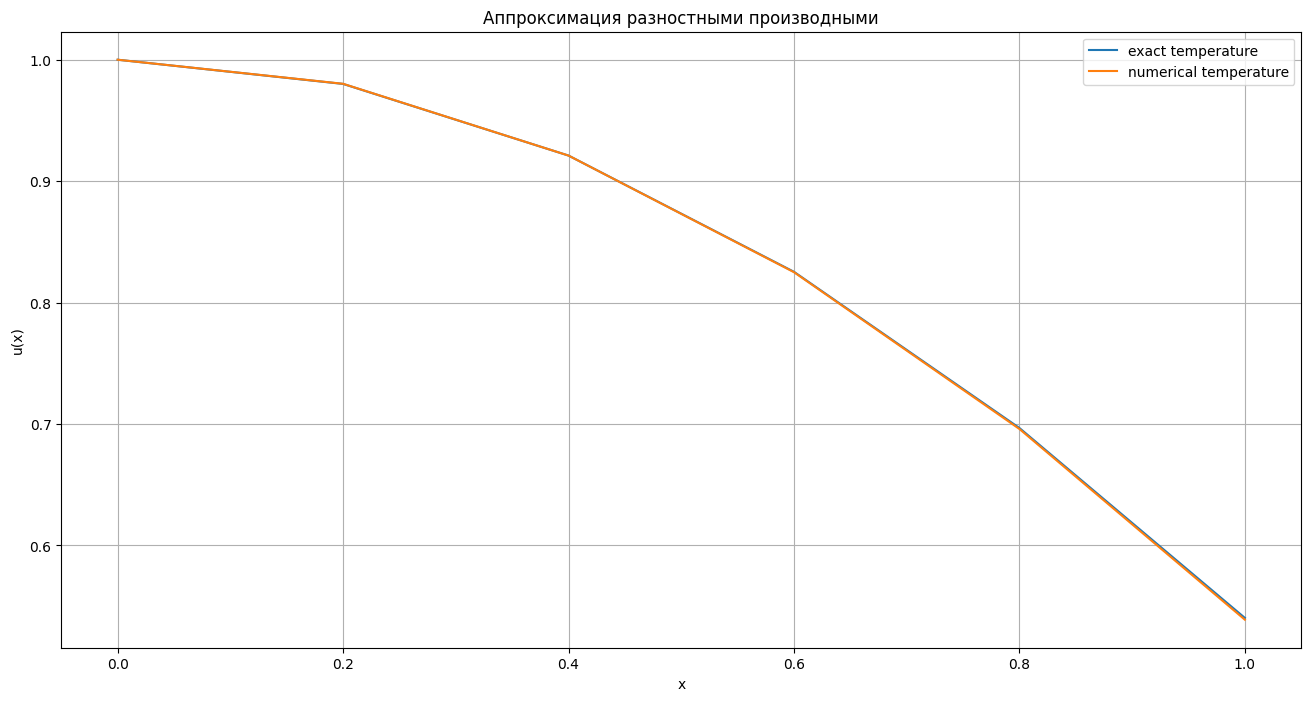

In [38]:
plt.figure(figsize=(16, 8))
plt.plot(x, u(x), label='exact temperature')
plt.plot(x, y, label='numerical temperature')
plt.title('Аппроксимация разностными производными')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

Как можно видеть из графика, приближенное решение максимально близко описывает точное решение задачи.

## Метод баланса

Итак, у нас есть разностная схема
$$
\begin{dcases}
			\dfrac{1}{h}\left(a_{i+1}\dfrac{y_{i+1} - y_i}{h} - a_i \dfrac{y_i - y_{i-1}}{h}\right)-d_iy_i = -\varphi_i,\ i=\overline {1,N-1}\\
			y_0 = \mu_1,\\
			-a_N \dfrac{y_N - y_{N-1}}{h} = \left(3\sigma_2 + \dfrac h2 d_N\right)y_N - \dfrac h2 \varphi_N;
		\end{dcases}
$$
где 
$$a_i = \left[ \dfrac 1h \int\limits_{x_{i-1}}^{x_i} \dfrac{dx}{4-x^2}\right]^{-1} = \left[ \dfrac 1h\cdot \dfrac 12 \ln \dfrac{2+x}{2-x}\Big|_{x_{i-1}}^{x_i}\right]^{-1} = \dfrac{2h}{\ln \dfrac{(2+x_i)(2-x_{i-1})}{(2-x_i)(2+x_{i-1})}},$$
	$$d_i=\dfrac 1h \int\limits_{x_{i-\frac12}}^{x_{i+\frac12}} x^2 dx = \dfrac 1 h\cdot \dfrac {x^3}{3}\Big | _{x_{i-\frac12}}^{x_{i+\frac12}}=\dfrac 1h\cdot \dfrac{(x_{i+\frac12}^3 - x_{i - \frac 12}^3)}{3},$$
	$$\varphi_i = \dfrac{1}{h} \int\limits_{x_{i-\frac12}}^{x_{i+\frac12}}[4\cos x - 2 x \sin x]dx = \dfrac 2 h (\sin x  + x \cos x)\Big | _{x_{i-\frac12}}^{x_{i+\frac12}}=$$ $$= \dfrac 2 h (\sin x_{i+\frac 12} - \sin x_{i-\frac 12} + x_{i+\frac 12}\cos x_{i+\frac 12} - x_{i-\frac 12}\cos x_{i-\frac 12}),$$
	$$d_N = \dfrac 2 h\cdot \dfrac {x^3}{3}\Big | _{1-\frac h 2}^{1} = \dfrac {2}{3h} - \dfrac{2 \left(1 - \frac h2\right)^3}{3h},$$ $$\varphi_N = \dfrac 4 h (\sin x  + x \cos x)\Big | _{1-\frac h2}^{1} = \dfrac 4 h \left(\sin 1 + \cos 1 - \sin \left(1-\dfrac h 2\right)- \left(1-\dfrac h 2\right) \cos \left(1-\dfrac h 2\right)\right).$$
Определим функции для вычисления коэффициентов

In [46]:
def a_i(x, h):
    return 2 * h / np.log((2+x)*(2-(x-h)) / ((2-x)*(2+(x-h))))

def d_i(x, h):
    return ((x+h/2)**3 - (x-h/2)**3)/(3*h) 

def phi_i(x, h):
    return 2/h * (np.sin(x+h/2) - np.sin(x-h/2) + (x+h/2)*np.cos(x+h/2) - (x-h/2)*np.cos(x-h/2))
                                                                                         
def d_N(h):
    return 2/(3*h) * (1 - (1-h/2)**3)

def phi_N(h):
    return 4/h * (np.sin(1) + np.cos(1) - np.sin(1-h/2) - (1-h/2)*np.cos(1-h/2))

Аналогично предыдущему пункту сведем решение разностной задачи к решению системы с трехдиагональной матрицей, определив коэффициенты следующим образом
$$\gamma_0 = 1,\ \beta_0 = 0,\ g_0 = \mu_1,$$
	$$\alpha_i = \dfrac{a_i}{h^2},\ \gamma_i = -\dfrac{a_{i} + a_{i+1}}{h^2} - d_i, \ \beta_i =\dfrac{a_{i+1}}{h^2},\ g_i = -\varphi_i,$$
	$$\alpha_N = \dfrac{a_N} h,\ \gamma_N = -\left[\dfrac{a_N}{h} + 3\sigma_2 + \dfrac h2 d_N\right],\ g_N = - \dfrac h 2 \varphi_N.$$
Вычислим все эти коэффициенты по указанным формулам

In [47]:
gamma = [1]
beta = [0]
g = [mu_1]
alpha = [0]
for i in range(1, N):
    alpha.append(a_i(x[i], h) / h**2)
    gamma.append(-(a_i(x[i],h) + a_i(x[i+1],h))/h**2 - d_i(x[i], h))
    beta.append(a_i(x[i+1], h) / h**2)
    g.append(-phi_i(x[i], h))
alpha.append(a_i(x[N], h)/h)
gamma.append(-(a_i(x[N], h) / h + 3 * sigma_2 + h/2 * d_N(h)))
g.append(-h/2 * phi_N(h))
beta.append(0)

Теперь определим приближенное решение разностной задачи как решение системы с трехдиагональной матрицей

In [48]:
y = tridiagonal_algorithm(alpha,beta,gamma,g)

Визуализируем полученные результаты

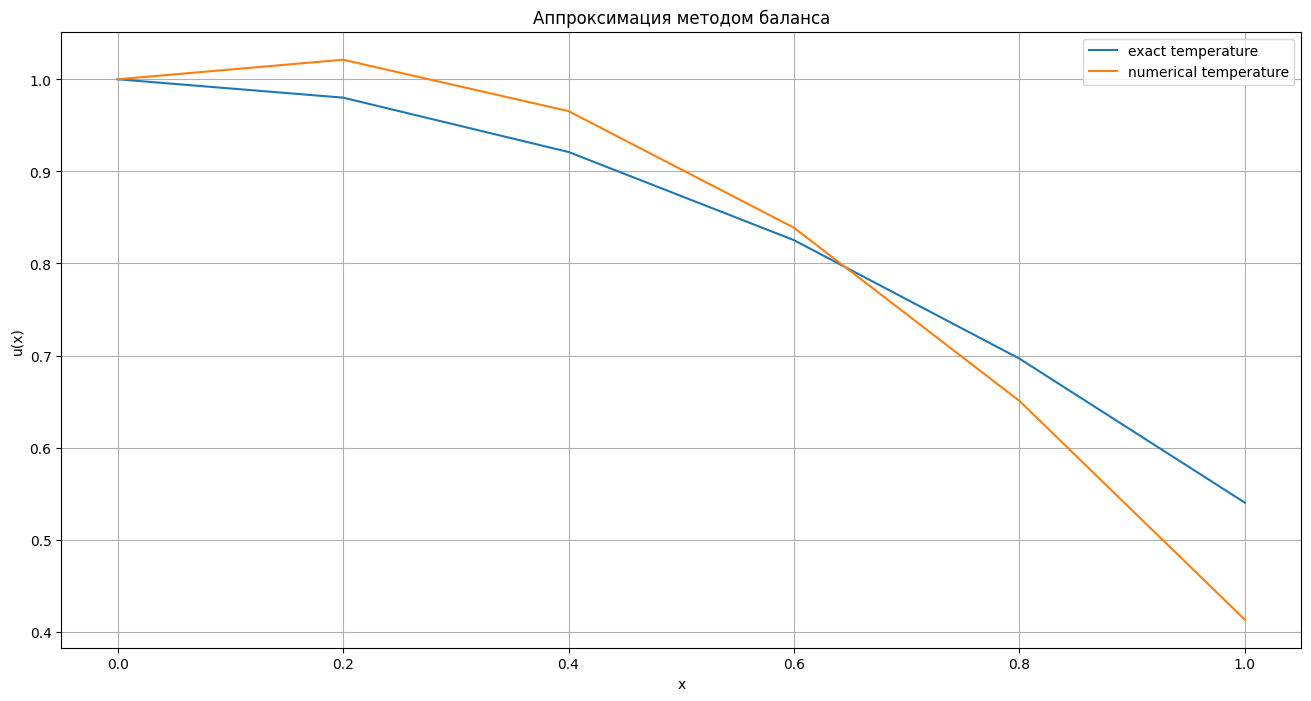

In [49]:
plt.figure(figsize=(16, 8))
plt.plot(x, u(x), label='exact temperature')
plt.plot(x, y, label='numerical temperature')
plt.title('Аппроксимация методом баланса')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

Как можно видеть из графика, приближенное решение неплохо описывает точное решение задачи.

## Метод Ритца

Итак, у нас есть разностная схема
$$\begin{dcases}
			\dfrac{a_i}{h^2}y_{i-1} - \left(\dfrac{a_i +a_{i+1}}{h}+d_i\right)y_i + \dfrac{a_{i+1}}{h^2}y_{i+1} = -\varphi_i,\ i=\overline {1,N-1}\\
			y_0 = \mu_1,\\
			-a_N \dfrac{y_N - y_{N-1}}{h} = \left(3\sigma_2 + \dfrac h2 d_N\right)y_N - \dfrac h2 \varphi_N;
		\end{dcases}
        $$
где
$$a_i = -h\alpha_{ii-1},\ \varphi_i = \dfrac 1 h \beta_i,\ d_i = \dfrac 1h(\alpha_{ii-1} +\alpha_{ii} + \alpha_{ii+1}),$$
$$\alpha_{ii} = \dfrac {1}{h^2}\left[ \left(4 x- \dfrac{x}{3}\right) \Big|_{x_{i-1}}^{x_{i+1}} + \left(\dfrac{x^5}{5} - \dfrac{x^4 x_{i-1}}{2} + \dfrac{x^3 x_{i-1}^2}{3}\right)\Big|_{x_{i-1}}^{x_i} + \left(\dfrac{x^5}{5} - \dfrac{x^4 x_{i+1}}{2} + \dfrac{x^3 x_{i+1}^2}{3}\right)\Big|_{x_{i}}^{x_{i+1}}\right],$$
	$$\alpha_{ii+1} = \dfrac{1}{h^2}\left[-\left(4 x- \dfrac{x}{3}\right) \Big|_{x_{i}}^{x_{i+1}} + \left(\dfrac{x^4(x_i + x_{i+1})}{4}-\dfrac 1 3 x_i x_{i+1}x^3 - \dfrac{x^5}{5}\right)\Big|_{x_{i}}^{x_{i+1}}\right],$$
	$$\alpha_{ii-1} = \dfrac{1}{h^2}\left[-\left(4 x- \dfrac{x}{3}\right) \Big|_{x_{i-1}}^{x_{i}} + \left(\dfrac{x^4(x_{i-1} + x_{i})}{4}-\dfrac 1 3 x_{i-1} x_{i}x^3 - \dfrac{x^5}{5}\right)\Big|_{x_{i-1}}^{x_{i}}\right],$$
	$$\beta_i = \dfrac 1 h \left[-2(x_{i-1}\sin x - x (x - x_{i-1})\cos x)\Big|_{x_{i-1}}^{x_i} + 2(x_{i+1}\sin x + x (x_{i+1} - x)\cos x)\Big|_{x_{i}}^{x_{i+1}}\right],$$
	$$ d_N = \dfrac{2}{12h^2}\left[x^3\cdot (4h+3x-4) \right]\Big|_{1-h}^{1},$$
	$$\varphi_N = \dfrac{2}{h^2} \left[2(h-1)\sin x + 2x(h+x-1)\cos x\right]\Big|_{1-h}^{1}.$$

In [50]:
def alpha_ii(x_i, x_im1, x_ip1, h):
    term1 = (4 * x_ip1 - x_ip1 / 3) - (4 * x_im1 - x_im1 / 3)
    term2 = ((x_i**5 / 5 - x_i**4 * x_im1 / 2 + x_i**3 * x_im1**2 / 3) -
             (x_im1**5 / 5 - x_im1**4 * x_im1 / 2 + x_im1**3 * x_im1**2 / 3))
    term3 = ((x_ip1**5 / 5 - x_ip1**4 * x_ip1 / 2 + x_ip1**3 * x_ip1**2 / 3) -
             (x_i**5 / 5 - x_i**4 * x_ip1 / 2 + x_i**3 * x_ip1**2 / 3))

    result = (1 / h**2) * (term1 + term2 + term3)
    return result

def alpha_ii_plus_1(x_i, x_ip1, h):
    term1 = -(4 * x_ip1 - x_ip1 / 3) + (4 * x_i - x_i / 3)
    term2 = ((x_ip1**4 * (x_i + x_ip1) / 4 - 1/3 * x_i * x_ip1 * x_ip1**3 - x_ip1**5 / 5) -
             (x_i**4 * (x_i + x_ip1) / 4 - 1/3 * x_i * x_ip1 * x_i**3 - x_i**5 / 5))

    result = (1 / h**2) * (term1 + term2)
    return result

def alpha_ii_minus_1(x_im1, x_i, h):
    term1 = -(4 * x_i - x_i / 3) + (4 * x_im1 - x_im1 / 3)
    term2 = ((x_i**4 * (x_im1 + x_i) / 4 - 1/3 * x_im1 * x_i * x_i**3 - x_i**5 / 5) -
             (x_im1**4 * (x_im1 + x_i) / 4 - 1/3 * x_im1 * x_i * x_im1**3 - x_im1**5 / 5))

    result = (1 / h**2) * (term1 + term2)
    return result

def beta_i(x_i, x_im1, x_ip1, h):
    term1 = -2 * ((x_i * np.sin(x_i) - x_i * (x_i - x_im1) * np.cos(x_i)) -
                  (x_im1 * np.sin(x_im1) - x_im1 * (x_im1 - x_im1) * np.cos(x_im1)))
    term2 = 2 * ((x_ip1 * np.sin(x_ip1) + x_ip1 * (x_ip1 - x_ip1) * np.cos(x_ip1)) -
                 (x_i * np.sin(x_i) + x_i * (x_ip1 - x_i) * np.cos(x_i)))

    result = (1 / h) * (term1 + term2)
    return result

def d_N(h):
    term1 = (1 - h)**3 * (4 * h + 3 * (1 - h) - 4)
    term2 = 1**3 * (4 * h + 3 * 1 - 4)
    result = (2 / (12 * h**2)) * (term2 - term1)
    return result

def phi_N(h):
    term1 = 2 * ((h - 1) * np.sin(1) + 1 * (h + 1 - 1) * np.cos(1)) - \
            2 * ((h - 1) * np.sin(1 - h) + (1 - h) * (h + (1 - h) - 1) * np.cos(1 - h))
    result = (2 / h**2) * term1
    return result

def a_i(x, h):
    return -h * alpha_ii_minus_1(x-h, x, h)

def d_i(x, h):
    return 1/h * (alpha_ii_minus_1(x-h, x, h) + alpha_ii(x, x-h, x+h, h) + alpha_ii_plus_1(x, x+h, h))

def phi_i(x, h):
    return 1/h * beta_i(x, x-h, x+h, h)

Как и в методе баланса сведем решение разностной задачи к решению системы с такой же трехдиагональной матрицей

In [54]:
gamma = [1]
beta = [0]
g = [mu_1]
alpha = [0]
for i in range(1, N):
    alpha.append(a_i(x[i], h) / h**2)
    gamma.append(-(a_i(x[i],h) + a_i(x[i+1],h))/h**2 - d_i(x[i], h))
    beta.append(a_i(x[i+1], h) / h**2)
    g.append(-phi_i(x[i], h))
alpha.append(a_i(x[N], h)/h)
gamma.append(-(a_i(x[N], h) / h + 3 * sigma_2 + h/2 * d_N(h)))
g.append(-h/2 * phi_N(h))
beta.append(0)

Теперь определим приближенное решение разностной задачи как решение системы с трехдиагональной матрицей

In [52]:
y = tridiagonal_algorithm(alpha,beta,gamma,g)

Визуализируем полученные результаты

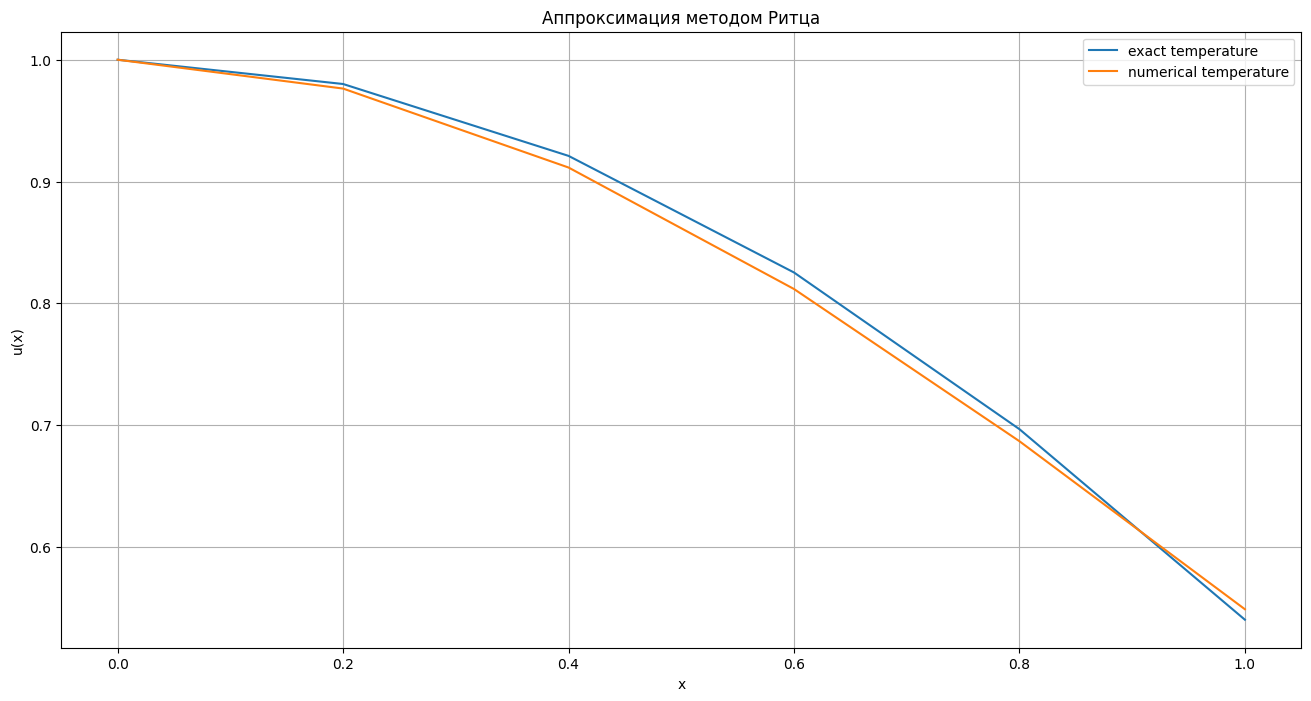

In [53]:
plt.figure(figsize=(16, 8))
plt.plot(x, u(x), label='exact temperature')
plt.plot(x, y, label='numerical temperature')
plt.title('Аппроксимация методом Ритца')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

Как можно видеть из графика, приближенное решение достаточно близко описывает точное решение задачи.

Таким образом, на основе проведенных исследований мы получили, что разностная схема, полученная путем замены производных разностными аналогами дает нам самую лучшую аппроксимацию. Разностная схема, построенная по методу Ритца дает достаточно близкую аппроксимацию, но хуже, чем разностная аппроксимация. Метод баланса дал нам самый худший результат.